**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


**Change Directory to Working Directory**

In [2]:
import os
os.chdir('/content/gdrive/My Drive/132A/Project')
!ls

 16QAM		     LLRs_4QAM_10.png   loss_16QAM_15.png   loss_BPSK_20.png
 4QAM		     LLRs_4QAM_15.png   loss_4QAM_10.png    Mixed
 BPSK		     LLRs_4QAM_20.png   loss_4QAM_15.png    Parameters.gsheet
'BPSK Trash Data'    LLRs_BPSK_10.png   loss_4QAM_20.png    Plots
 LLRs_16QAM_10.png   LLRs_BPSK_15.png   loss_BPSK_10.png
 LLRs_16QAM_15.png   LLRs_BPSK_20.png   loss_BPSK_15.png


**Load and Preprocess MATLAB Data**

In [0]:
import numpy as np
import pandas as pd
import scipy.io as sio

def unison_shuffled_copies(a, b, c):
    assert (len(a) == len(b)) and (len(a) == len(c)) and (len(b) == len(c))
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

sym_r = []
sym_i = []
LLR   = []
for i in range(4):
  x = sio.loadmat('BPSK/Raw Data/10 dB/BPSK_sym_10_' + str(i+1) + '.mat')
  y = sio.loadmat('BPSK/Raw Data/10 dB/BPSK_LLR_10_' + str(i+1) + '.mat')
  x_d = x['z_BPSK']
  LLR_d = y['LLR_BPSK']
  sym_r.append(np.asarray(x_d.real.ravel()))
  sym_i.append(np.asarray(x_d.imag.ravel()))
  LLR.append(np.asarray(LLR_d.ravel()))
  sym_r[i] = sym_r[i].reshape(1,-1)
  sym_i[i] = sym_i[i].reshape(1,-1)
  LLR[i] = LLR[i].reshape(1,-1)
  sym_r[i][0], sym_i[i][0], LLR[i][0] = unison_shuffled_copies(sym_r[i][0], sym_i[i][0], LLR[i][0])
  

**Neural Network Model Definition**

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate, BatchNormalization, Activation
from keras import optimizers
from keras.regularizers import l1

def llr_model():
    Nsym = 10000
    input1 = Input(shape=(Nsym, ))
    input2 = Input(shape=(Nsym, ))
    merged = Concatenate(axis=1)([input1, input2])

    dense1 = Dense(4096, kernel_initializer='random_normal', activation = 'relu')(merged)
    dropout1 = Dropout(0.1)(dense1)

    dense2 = Dense(2048, activation = 'relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)

    dense3 = Dense (1024, activation = 'relu')(dropout2)
    dropout3 = Dropout(0.4)(dense3)
    
    output = Dense (10000, activation = 'linear')(dropout3)
    model = Model(inputs=[input1, input2], output = output)
  
    Adam=optimizers.Adam(lr=1.0, beta_1=0.9, beta_2=0.999, decay=0.99, amsgrad=False)
    model.compile(loss="mean_squared_logarithmic_error", optimizer = 'Adam', metrics = ["mean_squared_error"], target_tensors = None)
    
    return model


Using TensorFlow backend.


**Train and Evaluate Neural Network Model**

In [5]:
import keras
import matplotlib.pyplot as plt

batchsize = 2**7  # training batch size
model = llr_model()

print (model.summary())
history = model.fit([sym_r[0], sym_i[0]], LLR[0], batch_size=batchsize, epochs = 500, validation_data = ([sym_r[1], sym_i[1]], LLR[1]), shuffle=True)

# Show performance
score = model.evaluate([sym_r[2], sym_i[2]], LLR[2], steps = batchsize)
print(score)

fig = plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.legend()
fig.savefig("loss_BPSK_10.png")
plt.close(fig)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 20000)        0           input_1[0][0]                    
                                                                 input_2[0][0]                    
_____________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`





Train on 1 samples, validate on 1 samples
Epoch 1/500





1/1 [==============================] - 10s 10s/step - loss: 5.7328 - mean_squared_error: 1689.8464 - val_loss: 5.6988 - val_mean_squared_error: 1686.3177
Epoch 2/500
1/1 [==============================] - 0s 123ms/step - loss: 3.9565 - mean_squared_error: 1518.0709 - val_loss: 5.6702 - val_mean_squared_error: 1703.0604
Epoch 3/500
1/1 [==============================] - 0s 124ms/step - loss: 3.0981 - mean_squared_error: 1631.7231 - val_loss: 5.7049 - val_mean_squared_error: 1736.7344
Epoch 4/500
1/1 [==============================] - 0s 122ms/step - loss: 2.5690 - mean_squared_error: 2647.7820 - val_loss: 5.7386 - val_mean_squared_error: 1779.1500
Epoch 5/500
1/1 [==============================] - 0s 123ms/step - loss: 2.4110 - mean_squared_error: 4724.2646 - val_loss: 5.7590 - val_mean_squared_error: 1817.0273
Epoch 6/500
1/1 [==============================] - 0s 123ms/step - loss: 2.2110 - mean_squared_error: 7483.1855 - va

**Plot True and NN LLRs**

1/1 [==============================] - 0s 44ms/step
[-26.148083  37.435368 -25.608551 ... -20.030031  53.271355 -51.41536 ]


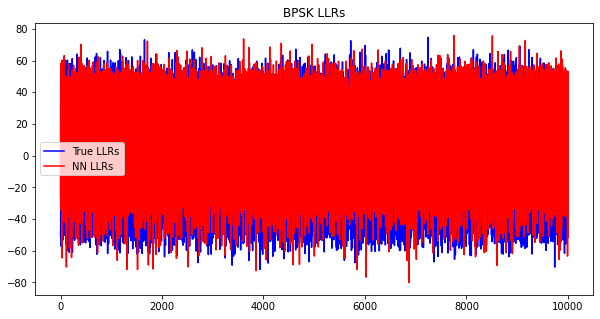

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
pred_llrs = model.predict([sym_r[3], sym_i[3]], verbose = 1, batch_size = None)
print (pred_llrs[0])
plt.plot(LLR[3][0],'b', label = 'True LLRs')
plt.plot(pred_llrs[0],'r', label = 'NN LLRs')
plt.title('BPSK LLRs')
plt.legend()
plt.show()
fig.savefig("LLRs_BPSK_10.png")

**Plot LLRs of Bit #0**

[-26.148083  37.435368 -25.608551 ... -20.030031  53.271355 -51.41536 ]
[-47.93746397  25.96562953 -51.38449608 ... -45.47696536  36.89119438
  37.34293535]


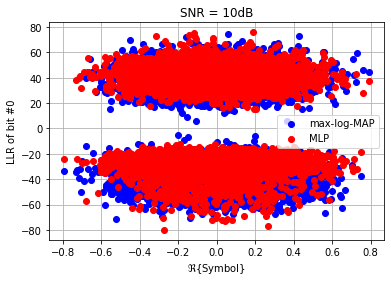

In [7]:
print(pred_llrs[0])
print(LLR[3][0])
fig2 = plt.figure()
plt.grid(True)
plt.scatter(sym_r[3], LLR[3], c='b', label = 'max-log-MAP',zorder=2)
plt.scatter(sym_r[3], pred_llrs[0], c='r', label = 'MLP',zorder=3)
plt.ylabel('LLR of bit #0')
plt.xlabel(r'$\Re$' + '{Symbol}')
plt.title('SNR = 10dB')
plt.legend()
fig2.savefig("Plots/BPSK_LLR_10.png")
plt.show()